Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Mean Squared Error (MSE): 8086346.88
R-squared Score (R²): 0.05


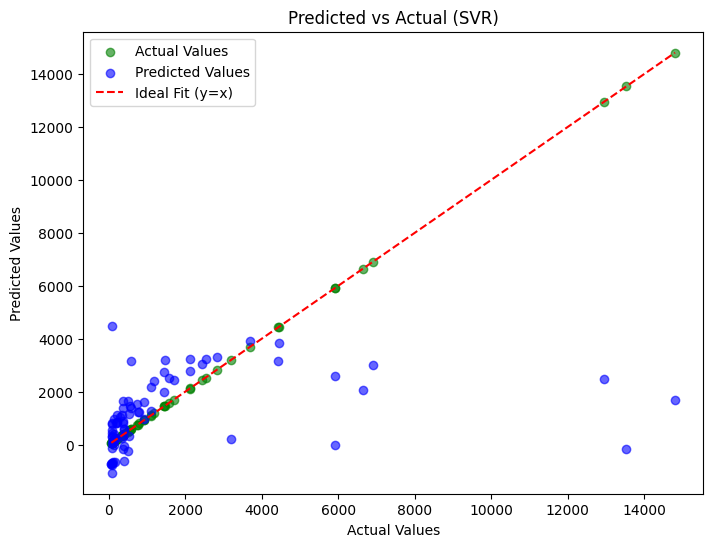

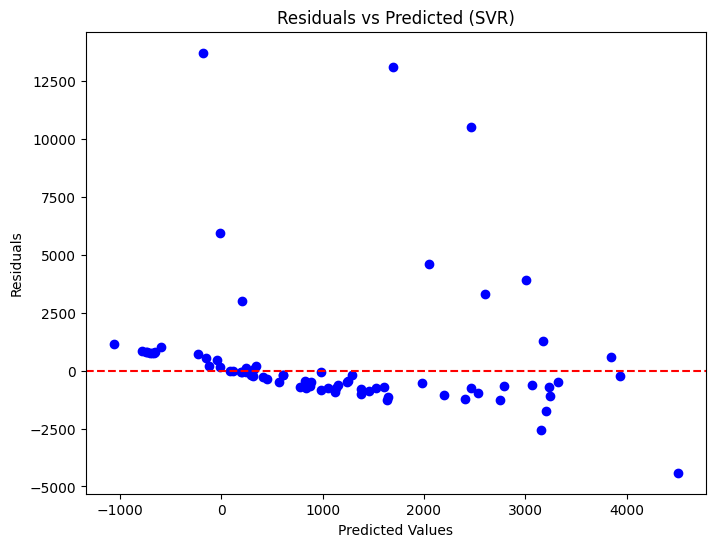

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


dataset = pd.read_csv('dataset.csv')

# Preprocessing
# Convert columns to numeric where possible
dataset = dataset.apply(pd.to_numeric, errors='coerce')

# Encode categorical data ('District')
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset['District'] = label_encoder.fit_transform(dataset['District'])

# Fill missing values with the mean
dataset.fillna(dataset.mean(), inplace=True)

# Create a target variable ('Total Cases')
dataset['Total Cases'] = dataset.iloc[:, 37:49].sum(axis=1)

# Drop unused columns (e.g., months used for summation and 'Year')
dataset = dataset.drop(dataset.columns[37:49], axis=1)
dataset = dataset.drop(columns=['Year'])

# Splitting data into features (X) and target (Y)
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

# Feature Scaling for SVR
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable Y
Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1))

# Hyperparameter Tuning for SVR
param_grid = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize SVR model
svr_model = SVR()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, Y_train_scaled)

# Best parameters found from GridSearchCV
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the test set
Y_pred_scaled = best_model.predict(X_test_scaled)

# Inverse transform predictions and Y_test for evaluation
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()
Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1)).flatten()

# Calculate Mean Squared Error (MSE) and R-squared
mse = mean_squared_error(Y_test_original, Y_pred)
r2 = r2_score(Y_test_original, Y_pred)

# Display results
print("Best Hyperparameters:", best_params)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared Score (R²): {r2:.2f}")

# Plot Predicted vs Actual with different colors
plt.figure(figsize=(8,6))

# Plot Actual Values in green
plt.scatter(Y_test_original, Y_test_original, color='green', label='Actual Values', alpha=0.6)

# Plot Predicted Values in blue
plt.scatter(Y_test_original, Y_pred, color='blue', label='Predicted Values', alpha=0.6)

plt.plot([min(Y_test_original), max(Y_test_original)], [min(Y_test_original), max(Y_test_original)], color='red', linestyle='--', label="Ideal Fit (y=x)")
plt.title('Predicted vs Actual (SVR)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Residuals vs Predicted plot
residuals = Y_test_original - Y_pred
plt.figure(figsize=(8,6))
plt.scatter(Y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')  # Zero residual line
plt.title('Residuals vs Predicted (SVR)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()
